In [1]:
import sys

sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_segmentation")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/simpler_models")


from train_fn import list_directory_tree_with_pathlib

In [2]:
import torch
# from EmetMamba_alpha import EmetMamba as model_alpha
# from EmetMamba_segmentation import EmetMamba as model_segmentation
# from EmetMamba import EmetMamba as model_K
# from EmetMamba_seg_and_regr import EmetMamba as model_seg_reg

In [3]:
# model_alpha = torch.load(
#     "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha/model_alpha_2_0p1_1e-4_8_8kexps"


In [4]:
from mamba_ssm import Mamba
from einops import rearrange
import torch.nn as nn

/home/m.lavaud/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class segmentation_model(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.lstm = nn.LSTM(
            input_size = d_model,
            hidden_size=d_state,
            num_layers = expand,
            bidirectional=True,
            batch_first=True,
            ).to(device)

        self.dense = nn.Linear(d_state * 2, 3).to(device)
        self.dropout = nn.Dropout(p=dropout).to(device)

    def forward(self, x):
        

        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        dense_out = self.dense(lstm_out)
        
        return dense_out  # No activation here ! It is done by the cross entropy loss


class K_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model*2, out_features=2).to(device)

        self.softplus = nn.Softplus()

    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])

        mamba_out = torch.cat((forward_mamba, backward_mamba), dim = -1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        out = torch.clamp(out, min=0, max=1e12)
        out[out < 1e-7] = 0
        return out


class alpha_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model*2, out_features=2).to(device)

        # self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])

        mamba_out = torch.cat((forward_mamba, backward_mamba), dim=-1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")
        mamba_out = self.dropout(mamba_out)
        
        out = self.fc(mamba_out)
        out = self.relu(out)
        out = torch.clamp(out, min=0, max = 2)
        
        return out

In [7]:
class all_at_the_same_time(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.model_K = K_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        self.model_alpha = alpha_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        self.segmentation = segmentation_model(
            d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        # self.segmentation = torch.load("300_epoch_lstm_10kfiles_classification_only")

    def forward(self, x):
        probas = self.segmentation(x)

        classes = torch.argmax(torch.softmax(probas, dim=2), dim=2)

        classes[x[:, :, 0] == 0] = 0

        classes[x[:, :, 0] == 0] = 0
        classes = classes.unsqueeze(-1)  # adding a dimension for the next step
        concat_entry = torch.cat((classes, x[:,:,:]), dim=2)

        alpha = self.model_alpha(concat_entry)

        K = self.model_K(concat_entry)

        return probas, alpha, K

In [9]:
model_seg_reg = torch.load("90epoch_lstmclass_bimambaalpha_D")

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
# model_alpha.eval()
# model_segmentation.eval()
# model_K.eval()
model_seg_reg.eval()

all_at_the_same_time(
  (model_K): K_regression(
    (mamba): Mamba(
      (in_proj): Linear(in_features=6, out_features=24, bias=False)
      (conv1d): Conv1d(12, 12, kernel_size=(4,), stride=(1,), padding=(3,), groups=12)
      (act): SiLU()
      (x_proj): Linear(in_features=12, out_features=33, bias=False)
      (dt_proj): Linear(in_features=1, out_features=12, bias=True)
      (out_proj): Linear(in_features=12, out_features=6, bias=False)
    )
    (flipped_mamba): Mamba(
      (in_proj): Linear(in_features=6, out_features=24, bias=False)
      (conv1d): Conv1d(12, 12, kernel_size=(4,), stride=(1,), padding=(3,), groups=12)
      (act): SiLU()
      (x_proj): Linear(in_features=12, out_features=33, bias=False)
      (dt_proj): Linear(in_features=1, out_features=12, bias=True)
      (out_proj): Linear(in_features=12, out_features=6, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
    (fc): Linear(in_features=1194, out_features=2, bias=True)
    (softplus): Softplus(

In [9]:
data_path = "track_2/"
directory_files = list_directory_tree_with_pathlib(data_path)

In [10]:

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return (ang1 - ang2) % (2 * np.pi)

In [11]:
import pandas as pd
import numpy as np


def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max -1, 6)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        data[:,0] = data[:,0] - data[0,0] + 1 #set first frame at 1
        data[:,1] = data[:,1] - data[0,1]  ## Set x and y at 0
        data[:,2] = data[:,2] - data[0,2] 
        Dx = data[1:,1] - data[:-1,1]
        Dy = data[1:,2] - data[:-1,2]
        MDx = np.zeros(len(Dx))
        MDy = np.zeros(len(Dx))
        angles = np.zeros(len(Dx))
        distance_displacement = np.sqrt(np.power(Dx,2) + np.power(Dy,2))
        #Displacement average

        for i in range(1, len(Dx)+1):
            MDx[i-1] = np.mean(data[i:,1] - data[:-i,1])
            MDy[i-1] = np.mean(data[i:,2] - data[:-i,2])

            A = (data[(i-1),1], data[(i-1),2])
            B = (data[i,1], data[i,2])
        
            # Computation of angles

            angles[i-1] = angle_between(A,B)



        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            # final_data[n, :, :] = data[:T_max, :]
            final_data[n,:,0] = Dx[:(T_max-1)]
            final_data[n,:,1] = Dy[:(T_max-1)]
            final_data[n,:,2] = MDx[:(T_max-1)]
            final_data[n,:,3] = MDy[:(T_max-1)]
            final_data[n,:,4] = distance_displacement[:(T_max-1)]
            final_data[n,:,5] = angles[:(T_max-1)]

            final_label[n, :, :] = label[:T_max-1, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, : (data.shape[0] -1), 0] = Dx
            final_data[n, : (data.shape[0] -1), 1] = Dy
            final_data[n, : (data.shape[0] -1), 2] = MDx
            final_data[n, : (data.shape[0] -1), 3] = MDy
            final_data[n, : (data.shape[0] -1), 4] = distance_displacement
            final_data[n, : (data.shape[0] -1), 5] = angles

    # Return the padded data and labels
    return final_data

In [12]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    # dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)
    df_padded = df_padded[:, :, :]
    # if nb_trajs % 20 == 0:

    #     for i in range(dataset.shape[0]):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    # else :
    #     for i in range(dataset.shape[0] - 1):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #     #On place i dans la dernière couche
    #     i+=1
    #     remaining_trajs = nb_trajs % 20
    #     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    #     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(df_padded.astype(np.float32))

In [13]:
results_alpha = {}
results_K = {}
results_segmentation = {}

with torch.no_grad():
    for file in directory_files:
        data = read_dataset(file)
        data = data.to("cuda")
        # results_alpha[file] = model_alpha(data).squeeze()
        # results_K[file] = model_K(data).squeeze()
        # results_segmentation[file] = torch.argmax(
        #     model_segmentation(data[:, :, 1:]).squeeze(), dim=-1
        # )

        segmentation, alpha, K = model_seg_reg(data)
        results_alpha[file] = alpha.squeeze()
        results_K[file] = K.squeeze()
        results_segmentation[file] = torch.argmax(segmentation.squeeze(), dim=-1)

        

In [14]:
keys = list(results_alpha.keys())

In [15]:
import matplotlib.pyplot as plt

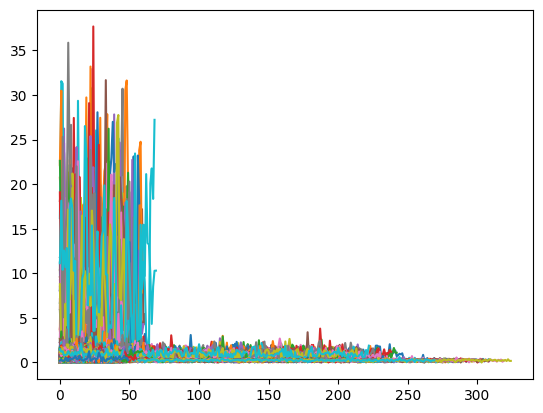

In [16]:
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 0])

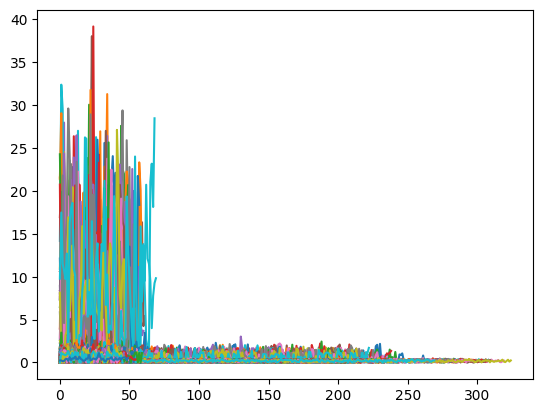

In [17]:
j = 0
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 1])
    j += len(K[:, 1])

In [18]:
results_alpha

{PosixPath('track_2/exp_10/trajs_fov_29.csv'): tensor([[0.4972, 0.4868],
         [1.0015, 1.0013],
         [1.0857, 1.0635],
         [0.2398, 0.2478],
         [0.8131, 0.8007],
         [0.2234, 0.2339],
         [1.4468, 1.4631],
         [1.9209, 1.9182],
         [0.3271, 0.3230],
         [0.5564, 0.5749],
         [0.5648, 0.5378],
         [0.6738, 0.6676],
         [1.0944, 1.0520],
         [0.8448, 0.8238],
         [0.2636, 0.2644],
         [0.9493, 0.9848],
         [1.0988, 1.1564],
         [0.5981, 0.6168],
         [0.7619, 0.7207],
         [1.6985, 1.6571],
         [1.1020, 1.0866],
         [0.1602, 0.1650],
         [1.8112, 1.7969],
         [1.2042, 1.1911],
         [0.7724, 0.7535],
         [1.7906, 1.7614],
         [1.5359, 1.5102],
         [0.5791, 0.4833],
         [1.3376, 1.3412],
         [1.3430, 1.3538],
         [0.9651, 0.9512],
         [1.1977, 1.1579],
         [1.3971, 1.3624],
         [1.2936, 1.2946],
         [1.7354, 1.7327],
         

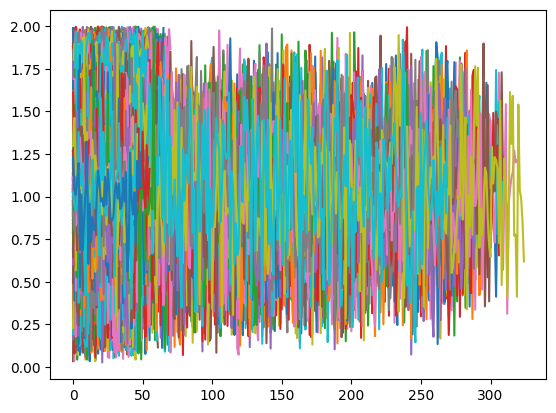

In [19]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 0])

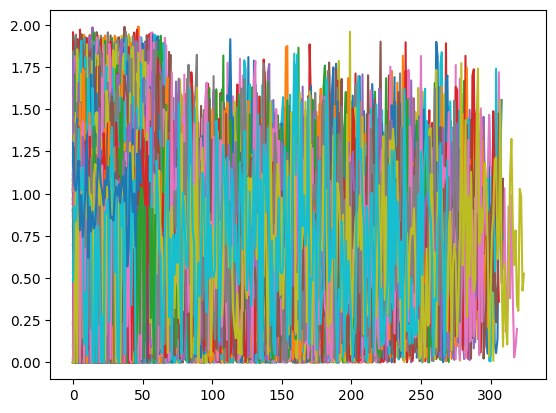

In [20]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 1])

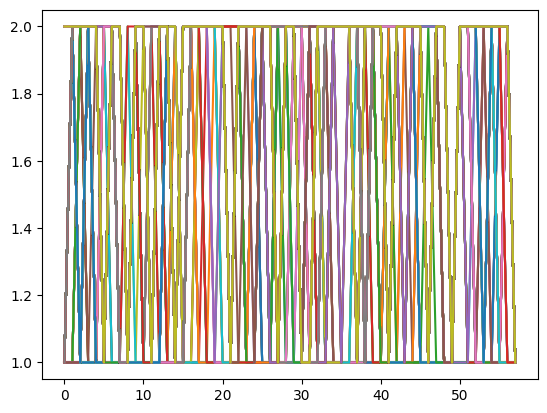

In [21]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    # segmentation[segmentation==0] = 1
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

In [22]:
## As a post-treatment task, we need to remove the segments which size are smaller than 3 as not possible

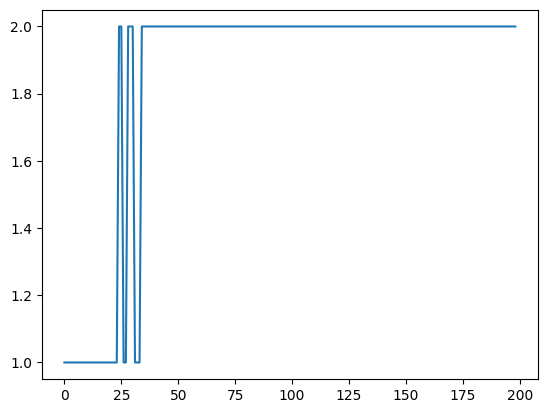

In [23]:
plt.plot(results_segmentation[keys[-3]][12,:].to("cpu"))

In [38]:
def change_small_sections(arr):
    # Find the start and end indices of sections
    diff = np.diff(arr)
    section_starts = np.where(diff != 0)[0] + 1
    section_starts = np.concatenate(([0], section_starts))
    section_ends = np.concatenate((section_starts[1:], [len(arr)]))
    # Iterate through sections
    for start, end in zip(section_starts, section_ends):
        section_length = end - start
        if section_length < 3:

            arr[start:end] =  3 - arr[start:end] 

    return arr

for i in keys:
        for j in range(results_segmentation[i].size(0)):
            
            results_segmentation[i][j,:] = change_small_sections(results_segmentation[i][j,:].to("cpu"))
                


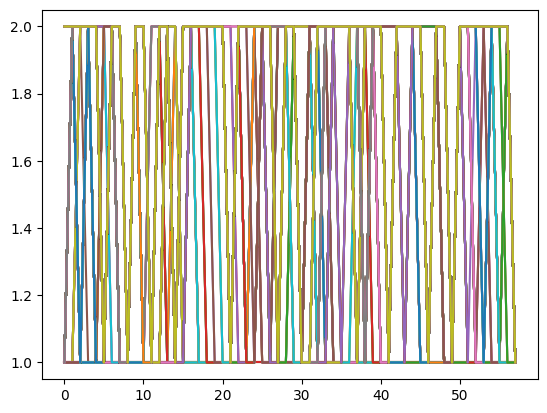

In [43]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    # segmentation[segmentation==0] = 1
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

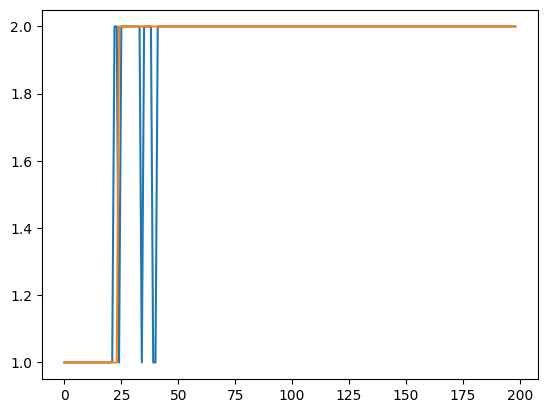

In [ ]:
## Remove all the samm sections



In [44]:
def generate_solution(file):
    
    df = pd.read_csv(file)

    total_sol = ""
    for id, group in df.groupby("traj_idx"):
        sol=""

        states = results_segmentation[file][int(id)].to("cpu") - 1
        alphas = results_alpha[file][int(id)].to("cpu")
        Ds = results_K[file][int(id)].to("cpu")
        unique_states = np.unique(states)
        
        if len(unique_states) == 1:
            
            if alphas[0] < 0.01:
                state = 1
            elif alphas[0] > 1.8:
                state = 3
            else:
                state = 2

            total_sol+= f"{int(id)},{Ds[0]},{alphas[0]},{state},{len(group["x"])}\n"
        else:

            state = [0,0]
            if alphas[0] < 0.001:
                state[0] = 1
            elif alphas[0] > 1.8:
                state[0] = 3
            else:
                state[0] = 2

            if alphas[1] < 0.001:
                state[1] = 1
            elif alphas[1] > 1.8:
                state[1] = 3
            else:
                state[1] = 2

            if Ds[0] < 1e-7:
                Ds[0] = 0
            if Ds[1] < 1e-7:
                Ds[1] = 0


            init_state = int(states[0])
            sol = f"{int(id)},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"

            for i in range(len(group["frame"]) -1):
                if int(states[i]) != init_state:
                    init_state = (init_state + 1) % 2
                    sol += f"{int(group["frame"].iloc[i])},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"
            sol+=f"{len(group["x"])}\n"
            total_sol+=sol

    return total_sol

In [45]:
dict_solutions = {}
j=0
for i in keys:
    j=0
    dict_solutions[i] = generate_solution(i)

In [46]:
keys = list(dict_solutions.keys())

In [47]:
print(generate_solution(keys[5]))

0,2.2590882778167725,1.2644654512405396,2,88,2.3006515502929688,1.2645823955535889,2,92,2.2590882778167725,1.2644654512405396,2,120,2.3006515502929688,1.2645823955535889,2,54
1,2.559478521347046,1.4630728960037231,2,167,2.7330756187438965,1.448055624961853,2,56
2,20.561939239501953,0.819926381111145,2,136
3,8.36052417755127,1.1604276895523071,2,24,7.877309322357178,1.1297789812088013,2,25,8.36052417755127,1.1604276895523071,2,26,7.877309322357178,1.1297789812088013,2,32,8.36052417755127,1.1604276895523071,2,96
4,2.9057669639587402,1.3497092723846436,2,62,2.8588109016418457,1.3519665002822876,2,21
5,12.08519172668457,1.161838173866272,2,33,11.837604522705078,1.1937634944915771,2,38,12.08519172668457,1.161838173866272,2,41
6,19.520492553710938,0.840760350227356,2,33
7,13.619590759277344,1.190132975578308,2,34
8,15.396321296691895,0.9114396572113037,2,166,13.566426277160645,0.9240967035293579,2,186,15.396321296691895,0.9114396572113037,2,47
9,13.310553550720215,0.11039839684963226,2,200
1

In [48]:
from copy import copy
from pathlib import Path

In [49]:
for i in keys:
    key = copy(i)
    file_name = i.parts[-1][6:-4] + ".txt"
    total_path = Path(*["solution", *i.parts[-3:-1],file_name])
    folder_path = Path(*total_path.parts[:-1])
    folder_path.mkdir(parents=True, exist_ok=True)

    with open(total_path, "w") as file:
        file.write(dict_solutions[key])


In [50]:
total_path

PosixPath('solution/exp_5/.ipynb_checkpoints/fov_1-checkpoint.txt')

In [51]:
dict_solutions[keys[0]]

'0,8.106966018676758,0.49721136689186096,2,133,7.368621826171875,0.4867933392524719,2,136,8.106966018676758,0.49721136689186096,2,188,7.368621826171875,0.4867933392524719,2,200\n1,10.513914108276367,1.0014904737472534,2,37\n2,10.897126197814941,1.0856863260269165,2,102,10.282089233398438,1.0635342597961426,2,103,10.897126197814941,1.0856863260269165,2,109,10.282089233398438,1.0635342597961426,2,116,10.897126197814941,1.0856863260269165,2,175,10.282089233398438,1.0635342597961426,2,183,10.897126197814941,1.0856863260269165,2,198,10.282089233398438,1.0635342597961426,2,113\n3,8.04879093170166,0.2397645264863968,2,22\n4,10.192117691040039,0.8131274580955505,2,87,7.883360862731934,0.8006748557090759,2,90,10.192117691040039,0.8131274580955505,2,95,7.883360862731934,0.8006748557090759,2,113,10.192117691040039,0.8131274580955505,2,114,7.883360862731934,0.8006748557090759,2,116,10.192117691040039,0.8131274580955505,2,117,7.883360862731934,0.8006748557090759,2,131,10.192117691040039,0.813127458

In [52]:
generate_solution(key)

'0,0.23165014386177063,1.2371118068695068,2,20,0.24282240867614746,1.2909269332885742,2,21,0.23165014386177063,1.2371118068695068,2,200\n1,0.34733814001083374,1.0400372743606567,2,142\n2,0.15508884191513062,1.0107189416885376,2,200\n3,0.210367813706398,1.1001538038253784,2,200\n4,0.4698292016983032,1.1957811117172241,2,19,0.38831090927124023,1.1956816911697388,2,22\n5,0.4073563814163208,0.6878052949905396,2,13,0.43899762630462646,0.7838762402534485,2,45,0.4073563814163208,0.6878052949905396,2,65,0.43899762630462646,0.7838762402534485,2,66,0.4073563814163208,0.6878052949905396,2,119,0.43899762630462646,0.7838762402534485,2,120,0.4073563814163208,0.6878052949905396,2,121,0.43899762630462646,0.7838762402534485,2,122,0.4073563814163208,0.6878052949905396,2,123,0.43899762630462646,0.7838762402534485,2,129,0.4073563814163208,0.6878052949905396,2,200\n6,0.16982266306877136,1.0123838186264038,2,200\n7,0.47865164279937744,0.686553418636322,2,18,0.6253977417945862,0.743803083896637,2,23,0.478651

In [ ]:
pd.read_csv(key)

,traj_idx,frame,x,y
0,0.0,0.0,161.164267,142.763482
1,0.0,1.0,161.077403,142.589036
2,0.0,2.0,161.354558,143.874786
3,0.0,3.0,161.169485,143.458609
4,0.0,4.0,159.270483,143.829008
...,...,...,...,...
6544,49.0,195.0,98.579725,116.656936
6545,49.0,196.0,98.723755,116.624656
6546,49.0,197.0,95.746428,116.273580
6547,49.0,198.0,95.677146,116.151651
